## Chapter 5
# Detection Using Cross Correlation With Whistler Kernel

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
from scipy import signal
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from sample_detector import SampleDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)

## **5.3 Spectrogram**

**Cropped spectrogram**

2013-04-22UT01:28:03.48279656.marion.vr2


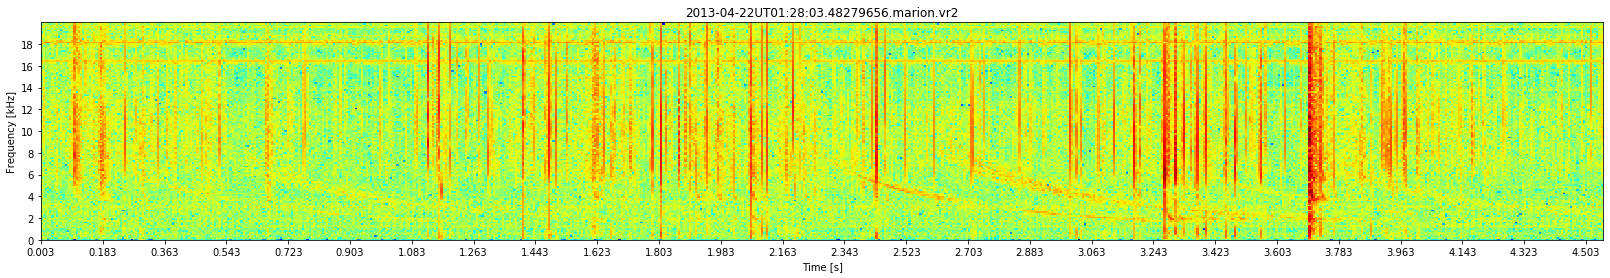

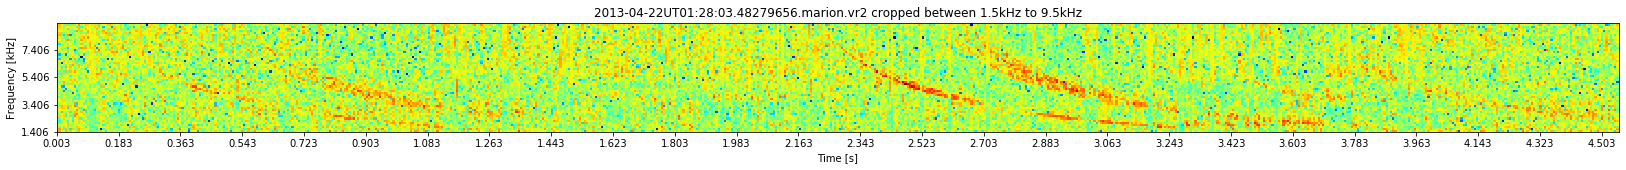

In [2]:
file = np.random.choice(database.get_train(),1)[0]
# file '2013-05-20UT16:02:23.18782156.marion.vr2'
# file = '2013-07-13UT17:44:16.56931930.marion.vr2'
# file = '2013-09-01UT15:04:07.94419414.marion.vr2'
file = '2013-04-22UT01:28:03.48279656.marion.vr2'
print(file)
sample = SampleDetector(dataset_loc, site, file)
freq_size = 4
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
transforms = ['slice', 'zscore']
transforms_params = [[1.5,9.5], ['None']]
sample.spectrogram_with_axis(log10=True)
sample.spectrogram_plot(figsize=sample.get_figsize(), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                           xaxis=True, yaxis=True,ticks=[0.18,2],
                           title=sample.get_file(), cmap='jet', cmap_show=False)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
sample.apply_transform(transforms, transforms_params)
sample.spectrogram_plot(figsize=sample.get_figsize(), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                           xaxis=True, yaxis=True,ticks=[0.18,2],
                           title=sample.get_file()+" cropped between 1.5kHz to 9.5kHz", cmap='jet', cmap_show=False)

## **5.4 Cross-Correlation**

341 3.5622966292134834
(52, 156)


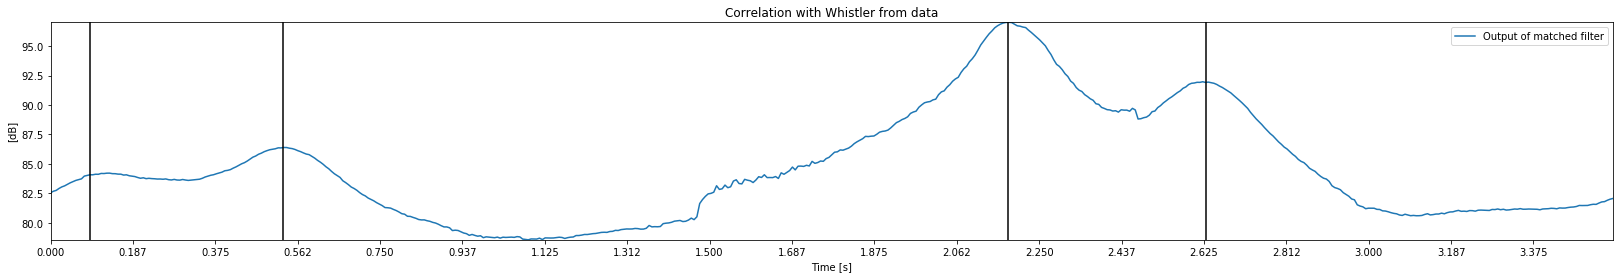

344 3.3832224719101127
(52, 184)


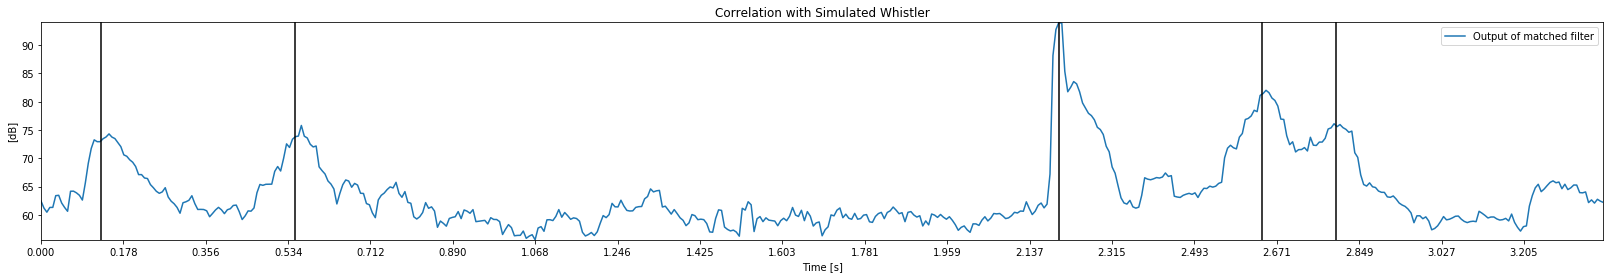

In [3]:
transforms, transforms_params = ['slice','zscore'],[[1.5,9.5],[None]]
detector, detector_params = 'ca_cfar', [15,10,1e-3]
sample.spectrogram_with_axis(log10=True)
sample.apply_transform(transforms, transforms_params)

figsize = sample.get_figsize()

# sample.spectrogram_plot(figsize=sample.get_figsize(),xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
#                            xaxis=True, yaxis=True,ticks=[0.2,2],title="Spectrogram: "+sample.get_file(), cmap='jet', cmap_show=False, vlines=[0.18,0.5,2.2,2.6,2.65,3.2,3.7])

kernel = sample.load_kernel('mean', [os.path.join(database_loc, site, 'kernels', 'kernel_data.h5')])
kernel = ((kernel-kernel.min())/(kernel.max()-kernel.min()))
corr = signal.correlate(10**sample.get_spectrogram(), kernel, mode='valid')[0]
print(np.argmax(corr), (len(corr))*sample.get_time_res())
print(kernel.shape)
sample.plot_corr_output(transforms, transforms_params, detector, detector_params, kernel=kernel, thresholds=[], detection=False, 
                        figsize=(figsize[0],4),title='Correlation with Whistler from data', vlines=[0.09,0.53,2.18,2.63])


kernel = sample.load_kernel('sim', [0.35,80,1])
corr = signal.correlate(10**sample.get_spectrogram(), kernel, mode='valid')[0]
print(np.argmax(corr), (len(corr))*sample.get_time_res())
print(kernel.shape)
sample.plot_corr_output(transforms, transforms_params, detector, detector_params, kernel=kernel, thresholds=[], detection=False, 
                        figsize=(figsize[0],4),title='Correlation with Simulated Whistler', vlines=[0.13,0.55,2.2,2.64,2.8])

## **5.4 Detector**

**Why we need an adaptive threshold**

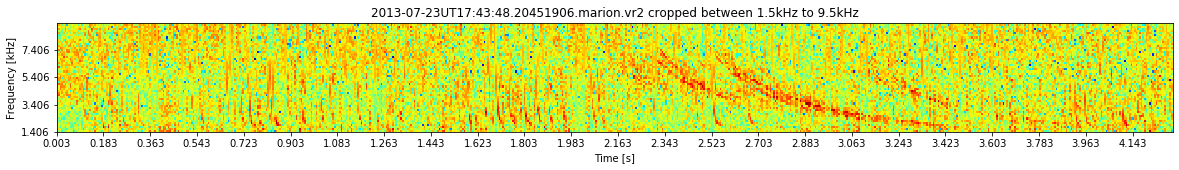

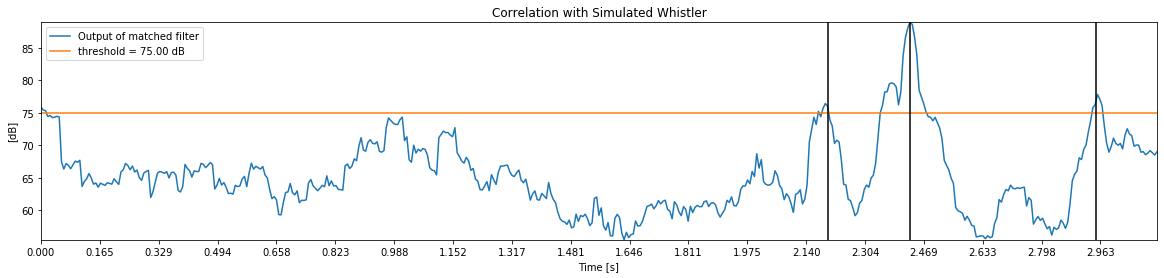

In [4]:
transforms, transforms_params = ['slice','zscore'],[[1.5,9.5],[None]]
detector, detector_params = 'ca_cfar', [15,10,1e-3]
# reason for adaptive threshold
file = '2013-07-23UT17:43:48.20451906.marion.vr2'

# file = '2013-04-22UT01:28:03.48279656.marion.vr2'
sample = SampleDetector(dataset_loc, site, file)
sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
figsize=sample.get_figsize()
sample.apply_transform(transforms, transforms_params)
sample.spectrogram_plot(figsize=sample.get_figsize(), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                           xaxis=True, yaxis=True,ticks=[0.18,2],
                           title=sample.get_file()+" cropped between 1.5kHz to 9.5kHz", cmap='jet', cmap_show=False)
kernel = sample.load_kernel('sim', [0.35,80,1])
sample.plot_corr_output(transforms, transforms_params, detector, detector_params, kernel=kernel, thresholds=[75], detection=False, 
                        figsize=(figsize[0],4),title='Correlation with Simulated Whistler', vlines=[2.2,2.43, 2.95])

**Window size**

unit cell = 1, 6.40ms
Noise duration = 10, 63.95ms
Guard duration = 7, 44.77ms
Window duration = 35, 223.83ms
One sided Window duration = 17, 111.92ms


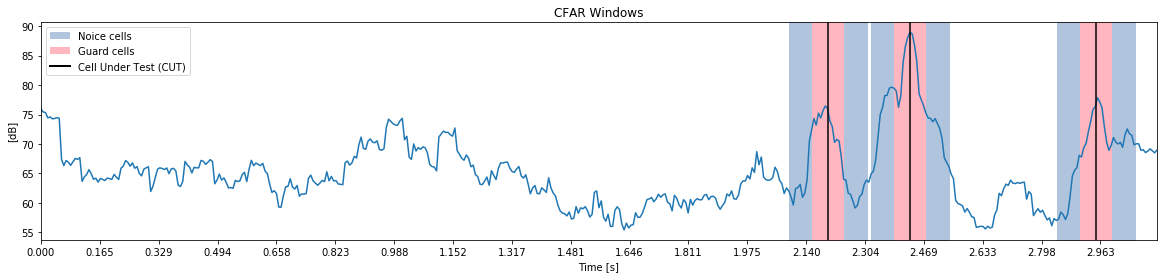

In [5]:
transforms, transforms_params = ['slice','zscore'],[[1.5,9.5],[None]]
N,G,pfa = 10,7,1e-3
detector, detector_params = 'ca_cfar', [N,G,pfa]

print('unit cell = %d, %.2fms'% (1,sample.get_time_res()*1e3))
print('Noise duration = %d, %.2fms'%(N,N*sample.get_time_res()*1e3))
print('Guard duration = %d, %.2fms'%(G,G*sample.get_time_res()*1e3))
print('Window duration = %d, %.2fms'%((1+2*N+2*G),(1+2*N+2*G)*sample.get_time_res()*1e3))
print('One sided Window duration = %d, %.2fms'%((N+G),(1+2*N+2*G)*sample.get_time_res()*1e3/2))

sample = SampleDetector(dataset_loc, site, file)
sample.spectrogram_with_axis(log10=True)
sample.apply_transform(transforms, transforms_params)

corr = signal.correlate(10**sample.get_spectrogram(), kernel, mode='valid')[0]
detect = sample.apply_cfar_detector(corr,detector, detector_params)[0]
x_axis = list(range(len(corr))*sample.get_time_res())

plt.figure(figsize=(figsize[0],4))
plt.plot(x_axis, 10*np.log10(corr**2))
# plt.plot(x_axis, np.log10(detect))

y1,y2 = plt.gca().get_ylim()
indices = [2.2,2.43, 2.95]
# indices = [0.13,0.55,2.2,2.64,2.8]
for ix in indices:
    lines = np.array([-G-N,-G,0,G,G+N])*sample.get_time_res()+ix
    plt.fill_between(lines[:2], y1=y1,y2=y2, color='lightsteelblue')
    plt.fill_between(lines[1:3], y1=y1,y2=y2,color='lightpink')
    plt.axvline(lines[2], color='black')
    plt.fill_between(lines[2:4], y1=y1,y2=y2,color='lightpink')
    plt.fill_between(lines[3:], y1=y1,y2=y2, color='lightsteelblue')  
plt.xticks(np.linspace(0,len(corr),20)*sample.get_time_res())
plt.autoscale(tight=True)
legend = [Patch(facecolor='lightsteelblue',label='Noice cells'),
          Patch(facecolor='lightpink',label='Guard cells'),
                  Line2D([0], [0], color='black', lw=2, label='Cell Under Test (CUT)')]
plt.legend(handles=legend, loc='upper left')
plt.xlabel('Time [s]')
plt.ylabel('[dB]')
plt.title('CFAR Windows')
plt.show()

**Type of cfar**

2013-08-03UT02:41:35.67331914.marion.vr2


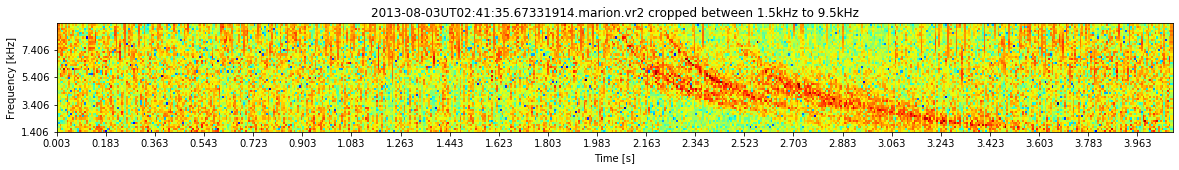

ca_cfar [10, 7, 0.02]


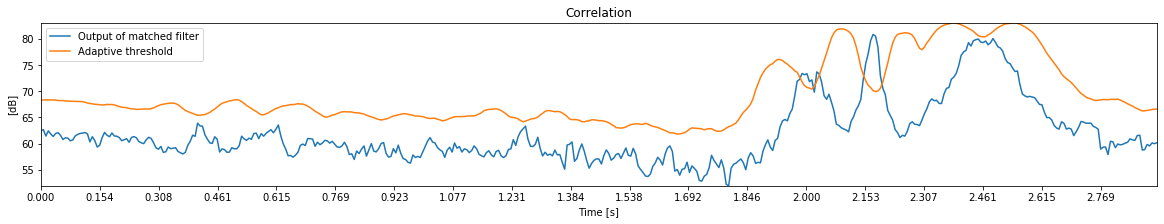

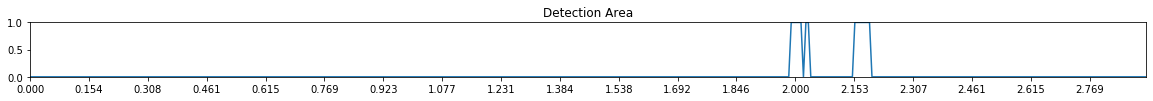

os_cfar [10, 7, 15, 0.02]


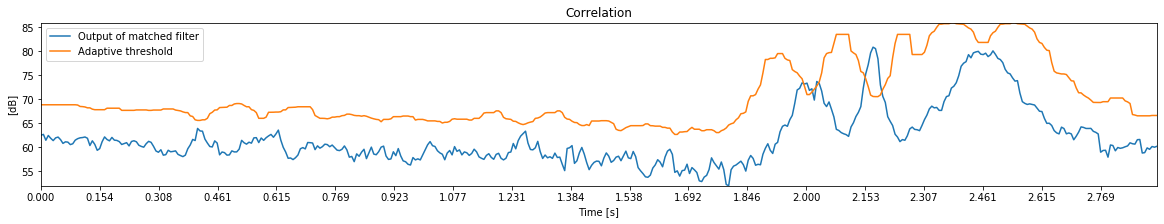

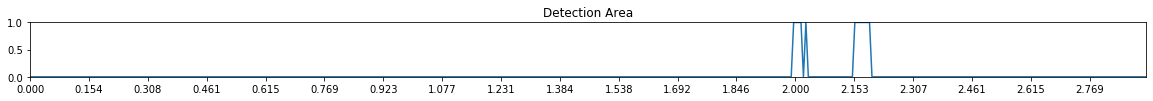

tm_cfar [10, 7, 5, 7, 0.02]


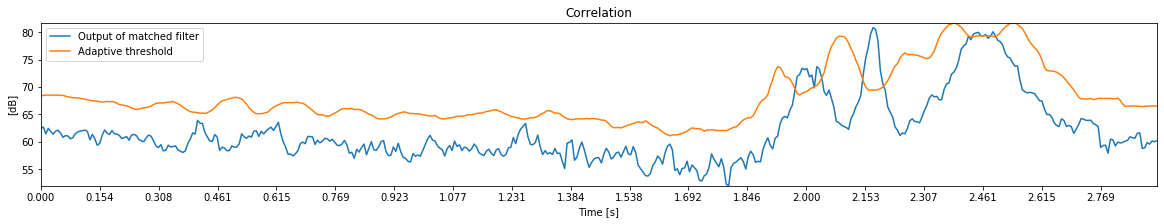

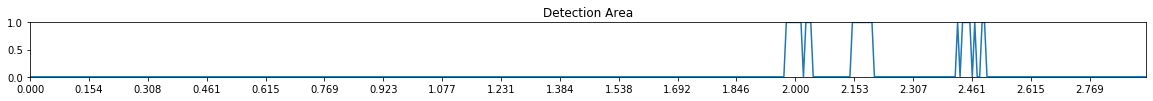

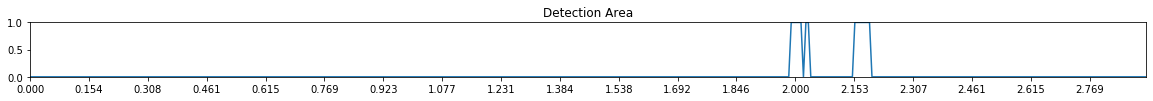

In [28]:
file = np.random.choice(database.get_train(),1)[0]
# file = '2013-07-26UT01:21:37.31171914.marion.vr2' # perfect perfect
# file = '2013-01-27UT01:02:20.38947602.marion.vr2' # perfect cfar example
# file = '2013-07-29UT02:52:11.93571922.marion.vr2'

# file = '2013-04-22UT01:28:03.48279656.marion.vr2'
# file = '2013-07-23UT17:43:48.20451906.marion.vr2'
# file = '2013-07-05UT19:09:09.53571914.marion.vr2'
# file = '2013-07-23UT17:43:48.20451906.marion.vr2'
# file = '2013-07-04UT18:57:16.16611930.marion.vr2'

# thick
# file = '2013-07-29UT13:35:32.63971914.marion.vr2'
# file = '2013-07-30UT22:42:37.67651922.marion.vr2'
# file = '2013-07-29UT14:10:55.64771914.marion.vr2'
# file = '2013-07-02UT16:02:40.59491914.marion.vr2'
# file ='2013-07-10UT19:35:10.41891938.marion.vr2'
print(file)
sample = SampleDetector(dataset_loc, site, file)
freq_size = 4
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
figsize=sample.get_figsize()
transforms = ['slice', 'zscore']#,'medfilt']
transforms_params = [[1.5,9.5], ['None']]#,[(3,3)]]

sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
sample.apply_transform(transforms, transforms_params)
sample.spectrogram_plot(figsize=sample.get_figsize(), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                           xaxis=True, yaxis=True,ticks=[0.18,2],
                           title=sample.get_file()+" cropped between 1.5kHz to 9.5kHz", cmap='jet', cmap_show=False)
kernel = sample.load_kernel('sim', [0.35,80,1])
figsize=sample.get_figsize()
figsize = (figsize[0],3)
N, G, pfa = 10,7, 2e-2
k, T1,T2 = 15, 5, 7
for detector, detector_params in zip(['ca_cfar','os_cfar','tm_cfar'],[[N,G,pfa],[N,G,k,pfa],[N,G,T1,T2,pfa]]):
    print(detector, detector_params)
    sample.plot_corr_output(transforms, transforms_params, detector, detector_params, kernel=kernel, thresholds=[], detection=True, figsize=figsize)
    sample.plot_detection_area(transforms, transforms_params, detector, detector_params, kernel=kernel, figsize=(figsize[0],1))
sample.plot_linear_fusion_cfar(transforms, transforms_params, kernel,[N,G,pfa],[N,G,k,pfa],[N,G,T1,T2,pfa], figsize=(figsize[0],1))

In [7]:
N = 10
XdB = np.linspace(0,20,20)
Pfa = (1/(1+(10**(XdB/10))/(2*N)))**(2*N)
for x,p in zip(XdB, Pfa):
    print('%.2f, %.2E'%(x,p))
# plt.figure()
# Pfa = np.linspace(0,0.001,10)
# X = 2*N*(Pfa**(-1/(2*N))-1)
# XdB = 10*np.log10(X)
# plt.plot(Pfa, XdB)

0.00, 3.77E-01
1.05, 2.91E-01
2.11, 2.10E-01
3.16, 1.40E-01
4.21, 8.40E-02
5.26, 4.48E-02
6.32, 2.07E-02
7.37, 8.03E-03
8.42, 2.56E-03
9.47, 6.53E-04
10.53, 1.30E-04
11.58, 1.96E-05
12.63, 2.24E-06
13.68, 1.90E-07
14.74, 1.21E-08
15.79, 5.79E-10
16.84, 2.13E-11
17.89, 6.14E-13
18.95, 1.43E-14
20.00, 2.74E-16
